In [498]:
import math
import os
import copy
import time
import warnings
import torch

from tempfile import TemporaryDirectory
from typing import Tuple
from typing import List
from typing import Optional, Tuple
from typing import Optional, Any, Union, Callable

from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import dataset
from transformers import PreTrainedModel
from torch.nn.modules.linear import NonDynamicallyQuantizableLinear
from torch.nn.init import constant_, xavier_normal_, xavier_uniform_
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.nn.modules.container import ModuleList
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.linear import Linear
from torch.nn.modules.normalization import LayerNorm
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from transformers import PretrainedConfig
from transformers import OpenAIGPTConfig, AutoTokenizer, OpenAIGPTLMHeadModel 

from datasets import load_dataset
import matplotlib.pyplot as plt
import common_utils

In [104]:
import random

# Construct the B matrix
d = 23

B = torch.zeros(2*d, d)

w = torch.randn(2*d)

def dselu(v):
    return torch.sigmoid(v) * (1 + v * (1 - torch.sigmoid(v)))

def drelu(v):
    return (v > 0).float()

def dsqr(v):
    return v

for i in range(d):
    for j in range(d):
        f = torch.zeros(2*d)
        f[i] = 1
        f[j + d] = 1
        
        g = torch.zeros(d)
        
        #rand_idx = random.randint(0,d-1)
        #g[rand_idx] = 1
        g[(i + j) % d] = 1
        
        # some weights depends on f
        # weight = 1 if torch.dot(f, w) > 0 else 0
        # weight = torch.sigmoid(torch.dot(f, w))
        # random noise
        # weight = torch.randn(1)
        weight = dselu(torch.dot(f, w))
        
        B += weight * torch.outer(f, g)

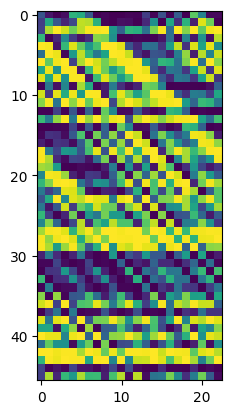

In [43]:
plt.imshow(B)

In [22]:
U, D, V = torch.svd(B)

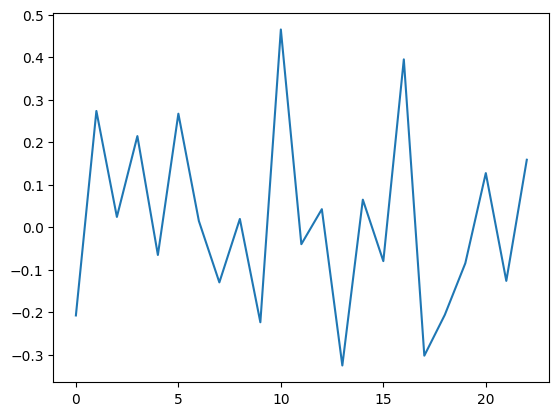

In [25]:
plt.plot(V[2,:])

In [260]:
1/23

0.043478260869565216

In [494]:
d = 97

# multiplication table
mul_table = torch.zeros(d+1, d+1, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
# put a zero
mul_table[d, :] = d
mul_table[:, d] = d

# distribution of each entry
probs = torch.ones(d+1, d+1)
probs[d, :] = 1
probs[:, d] = 1


In [480]:
# multiplication table
mul_table = torch.zeros(d, d, dtype=torch.int)

for i in range(d):
    for j in range(d):
        mul_table[i, j] = (i + j) % d
        
#probs = torch.ones(d, d)
# probs = torch.rand(d, d) * 0.2 + 1

# Sample 80% training and 20% test
probs = (torch.rand(d, d) > 0.1).float()

In [495]:
N1 = mul_table.shape[0] 
N2 = mul_table.shape[1] 
N3 = mul_table.max() + 1

N = N1 * N2

F1 = torch.zeros(N1, N2, N1)
F2 = torch.zeros(N1, N2, N2)
G = torch.zeros(N1, N2, N3)

for i in range(N1):
    for j in range(N2):
        rho = probs[i, j]
        
        F1[i, j, i] = rho
        F2[i, j, j] = rho
        
        if random_input:
            # random fact
            random_idx = random.randint(0, N3-1)
            if random.random() > 0.9:
                G[i, j, random_idx] = rho
        else:
            G[i, j, mul_table[i, j]] = rho

F1 = F1.view(-1, N1)
F2 = F2.view(-1, N2)
F = torch.cat([F1, F2], dim=1)
F = F - F.mean(dim=0, keepdim=True)

G = G.view(-1, N3)
G = G - G.mean(dim=0, keepdim=True)

In [496]:
w0 = torch.randn(N1+N2) * 0.01
v0 = torch.randn(N3) * 0.01

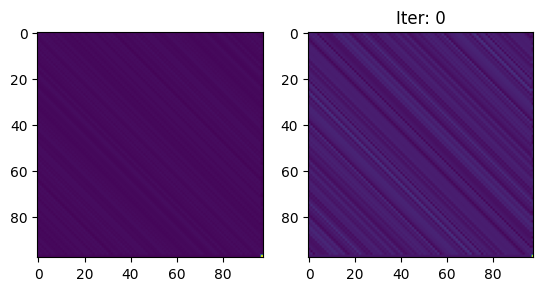

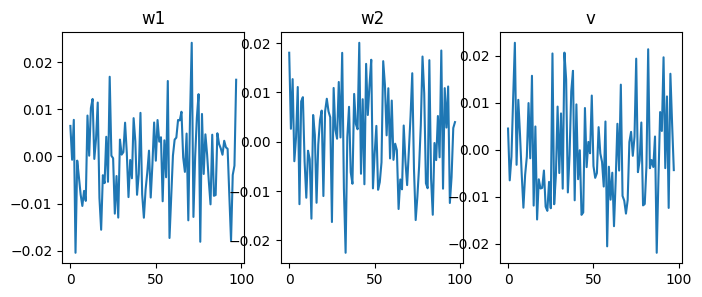

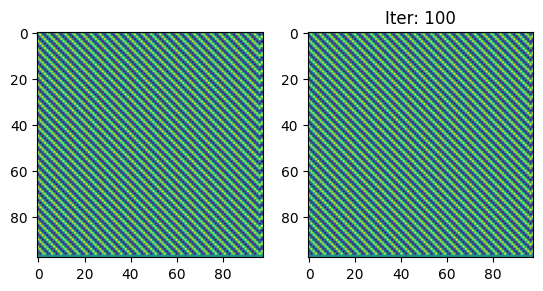

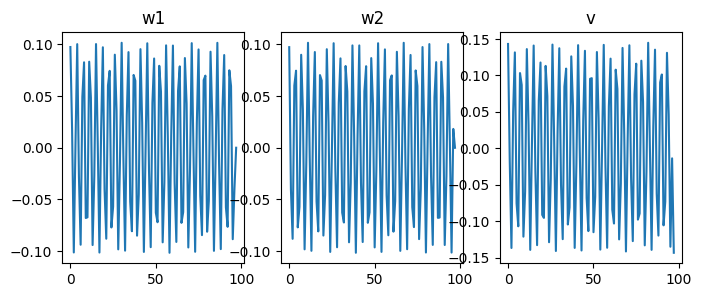

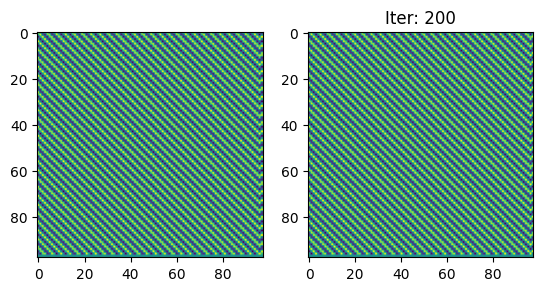

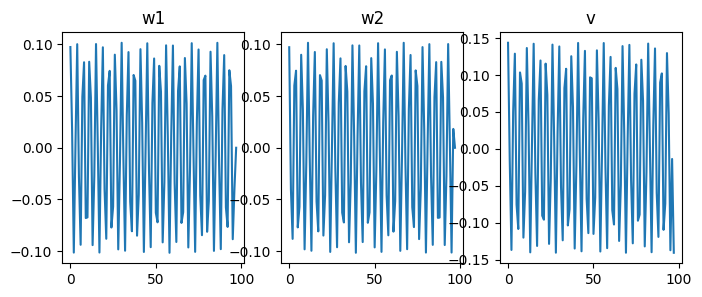

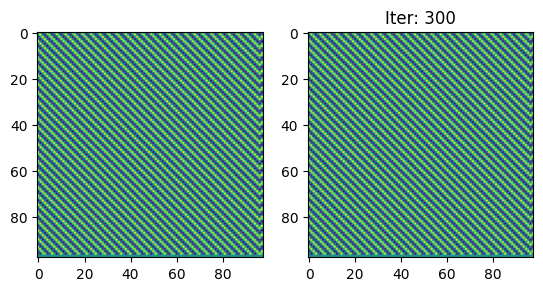

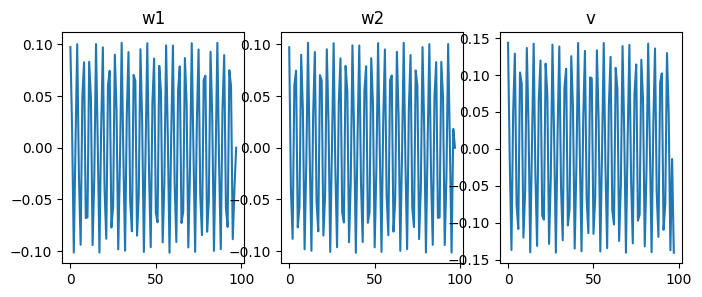

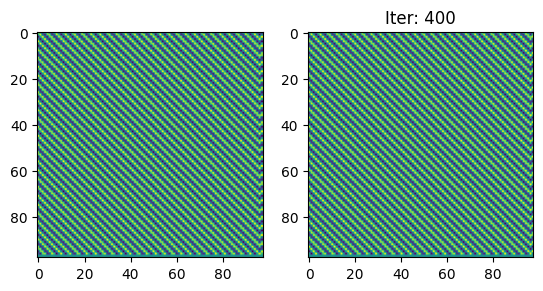

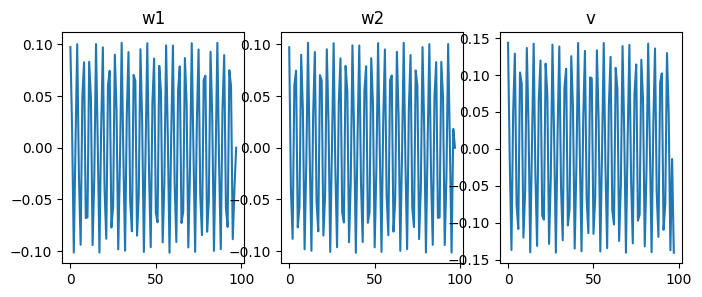

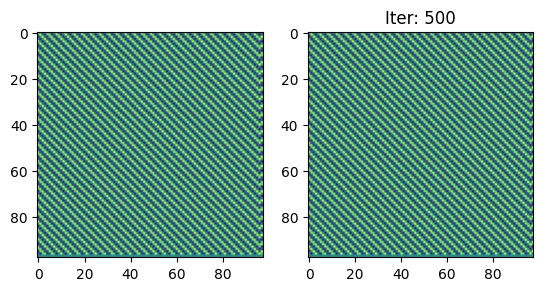

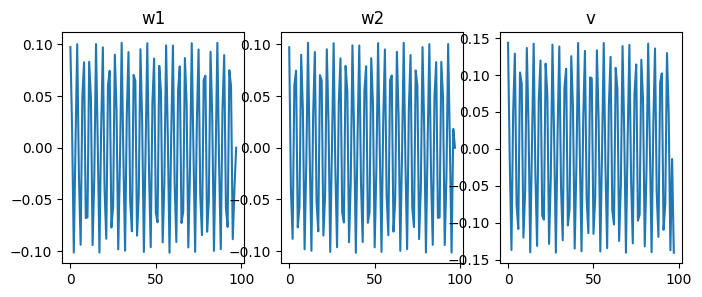

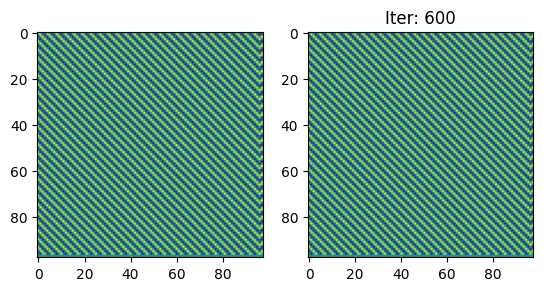

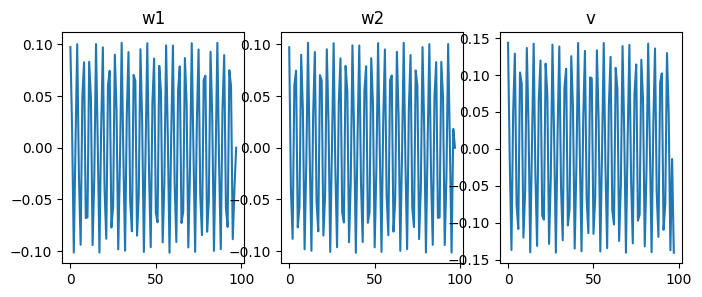

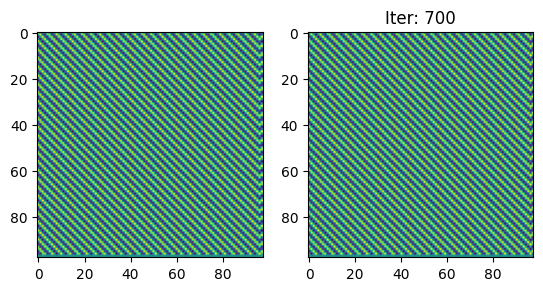

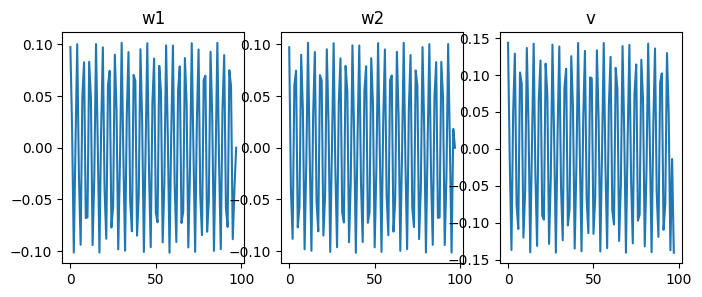

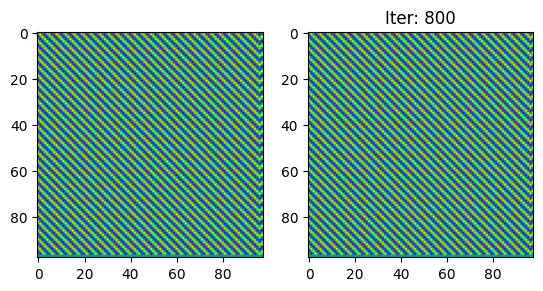

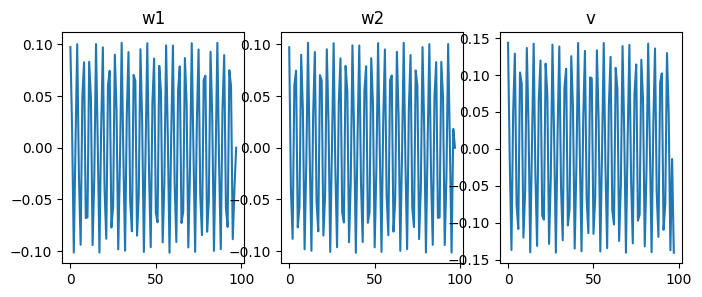

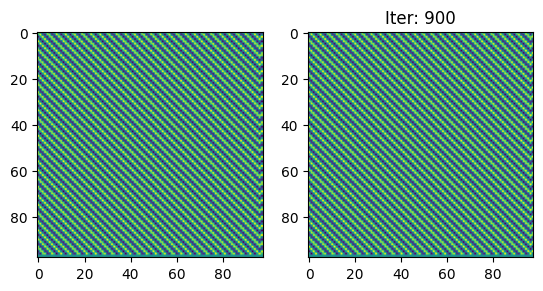

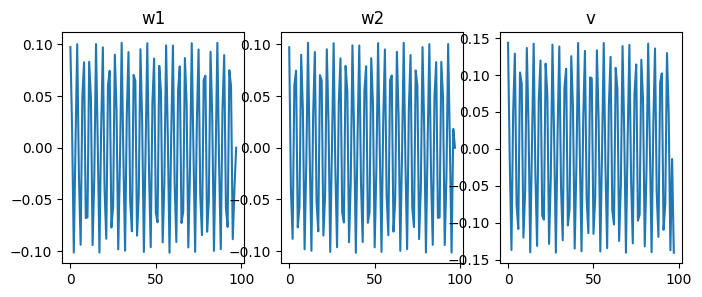

In [497]:
w = w0[:]
v = v0[:]

alpha = 0.01
eta = 0.1
nIter = 1000

wt = torch.zeros(N1+N2, nIter)
vt = torch.zeros(N3, nIter)

for t in range(nIter):    
    weight = dsqr(F @ w)
    # weight = dselu(F @ w)
    # B is (n1+n2)-by-n3
    B = (F.t() * weight[None,:]) @ G
    
    if t % 100 == 0:
        plt.subplot(1, 2, 1)
        plt.imshow(B[:N1,:])
        plt.subplot(1, 2, 2)
        plt.imshow(B[N1:,:])
        plt.title(f"Iter: {t}")
        plt.show()
        
        plt.figure(figsize=(8,3))
        plt.subplot(1, 3, 1)
        plt.plot(w[:N1])
        
        plt.title("w1")
        plt.subplot(1, 3, 2)
        plt.plot(w[N1:])
        plt.title("w2")

        plt.subplot(1, 3, 3)
        plt.plot(v)
        plt.title("v")

        plt.show()

    #
    deltaw = 2 * B @ v
    deltav = B.t() @ w

    w = w + deltaw * alpha - eta * w
    v = v + deltav * alpha - eta * v
    
    # w = w - w.mean()
    # v = v - v.mean()
    
    w = w / w.norm()
    v = v / v.norm()
    
    wt[:,t] = w
    vt[:,t] = v


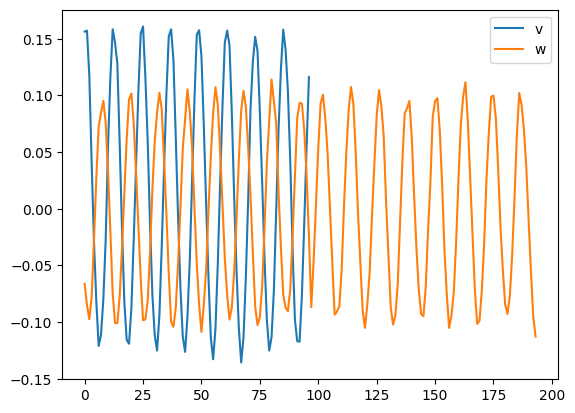

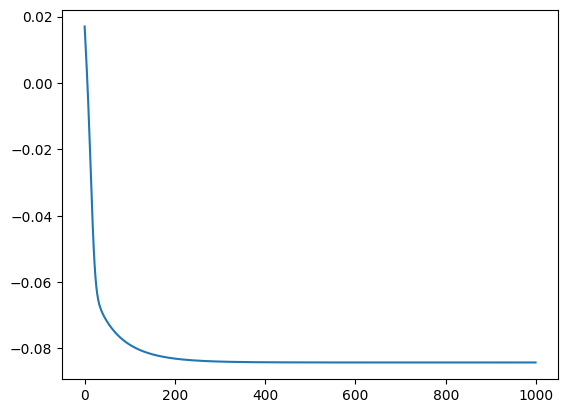

In [289]:
plt.plot(wt[-1,:])

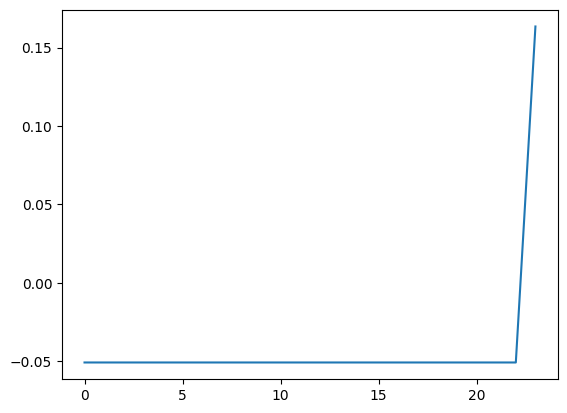

In [262]:
plt.plot(B[d,:])

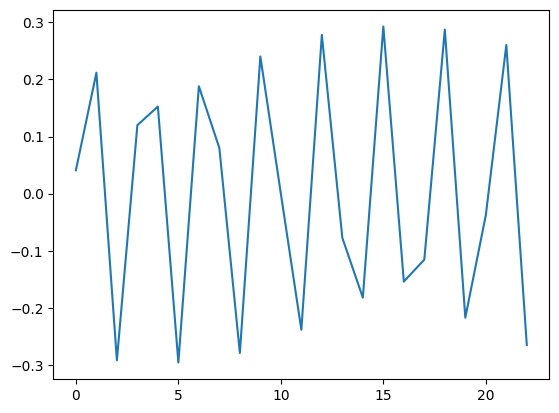

In [70]:
plt.plot(v)